# Traditional classification methods with dimensionality reduction

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

#df
emotion_df = pd.read_csv('./emotion.csv')
emotion_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,neutral
1,0.247559,0.372559,0.505371,0.513672,0.512207,0.504395,0.490723,0.474609,0.479492,0.477051,...,0.826274,-3.222172,1.388915,4.013056,2.990819,2.015841,0.986858,-1.120504,-0.159986,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.006713,0.006601,0.006483,0.006356,0.006218,0.006066,0.005919,0.005759,0.005588,neutral
3,0.255859,0.387695,0.515625,0.509766,0.517578,0.515137,0.520996,0.518555,0.506836,0.500977,...,2.064635,0.224009,1.975531,-0.864343,-1.678869,-3.831218,-0.846629,-0.629172,3.793445,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


## Función útil

In [3]:
def evaluate_model(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return acc, f1, recall, precision, cm

## Preparation

Cleaning

In [4]:
emotion_df=emotion_df.fillna(0)
print(emotion_df.isna().any())
emotion_df.shape
np.sum(emotion_df.isna())

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


c:\Users\Matías\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

Data separation

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Cargar X y Y
X = emotion_df.iloc[: ,:-1].values  # car
Y = emotion_df['Emotions'].values  # lab


# Escalar ANTES de dividir los datos (importante)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Dividir datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2, shuffle=True)

## Reducción de la dimensionalidad (LDA y UMAP)

In [ ]:
#LDA
lda = LDA(n_components=5)
X_train_lda = lda.fit_transform(x_train, y_train)
X_test_lda = lda.transform(x_test)

In [6]:
#UMAP
umap_model = UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(x_train)
X_test_umap = umap_model.transform(x_test)

c:\Users\Matías\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


## Clasificación 

In [7]:
classifiers = {
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

results = {}

### LDA

#### SVM

In [12]:
# SVM con LDA
svm_lda = classifiers['SVM']
svm_lda.fit(X_train_lda, y_train)
y_pred_svm_lda = svm_lda.predict(X_test_lda)
results['SVM with LDA'] = evaluate_model(y_test, y_pred_svm_lda)

NameError: name 'X_train_lda' is not defined

#### Decision Tree

In [13]:
dt_lda = classifiers['Decision Tree']
dt_lda.fit(X_train_lda, y_train)
y_pred_dt_lda = dt_lda.predict(X_test_lda)
results['Decision Tree with LDA'] = evaluate_model(y_test, y_pred_dt_lda)

NameError: name 'X_train_lda' is not defined

#### KNN

In [14]:
knn_lda = classifiers['KNN']
knn_lda.fit(X_train_lda, y_train)
y_pred_knn_lda = knn_lda.predict(X_test_lda)
results['KNN with LDA'] = evaluate_model(y_test, y_pred_knn_lda)

NameError: name 'X_train_lda' is not defined

### UMAP

#### SVM

In [8]:
# SVM con UMAP
svm_umap = classifiers['SVM']
svm_umap.fit(X_train_umap, y_train)
y_pred_svm_umap = svm_umap.predict(X_test_umap)
results['SVM with UMAP'] = evaluate_model(y_test, y_pred_svm_umap)

c:\Users\Matías\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Decision Tree

In [9]:
dt_umap = classifiers['Decision Tree']
dt_umap.fit(X_train_umap, y_train)
y_pred_dt_umap = dt_umap.predict(X_test_umap)
results['Decision Tree with UMAP'] = evaluate_model(y_test, y_pred_dt_umap)

#### KNN

In [10]:
knn_umap = classifiers['KNN']
knn_umap.fit(X_train_umap, y_train)
y_pred_knn_umap = knn_umap.predict(X_test_umap)
results['KNN with UMAP'] = evaluate_model(y_test, y_pred_knn_umap)

## Evaluación

SVM with UMAP - Accuracy: 0.21634121274409043, F1-score: 0.1892810870076314, Recall: 0.21634121274409043, Precision: 0.2087228646491947
Confusion Matrix:
[[162 363 189 632 134  51   0]
 [109 559  76 537 147 121   0]
 [143 284 242 649 163  71   0]
 [ 90 246 157 800 143  80   0]
 [120 256 176 705 221  79   0]
 [141 370 119 602 167 121   0]
 [ 34  43  75 203 144   6   0]]



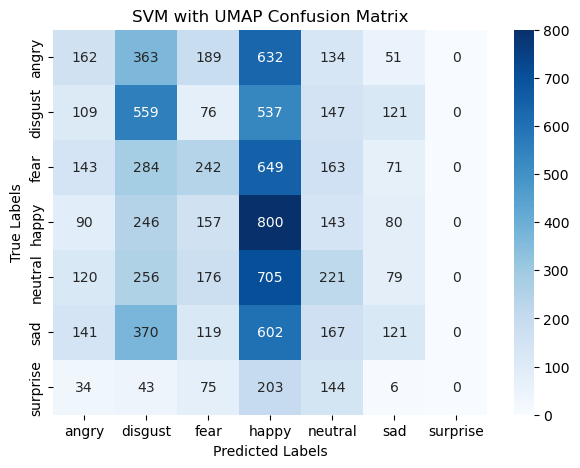

Decision Tree with UMAP - Accuracy: 0.3135662898252826, F1-score: 0.31372915938153206, Recall: 0.3135662898252826, Precision: 0.31475046148078367
Confusion Matrix:
[[515 181 253 255 177 100  50]
 [155 462 188 163 196 343  42]
 [240 173 440 218 179 243  59]
 [209 176 230 450 235 148  68]
 [105 201 187 226 477 274  87]
 [ 89 256 198 143 246 552  36]
 [ 36  39  52  98  84  41 155]]



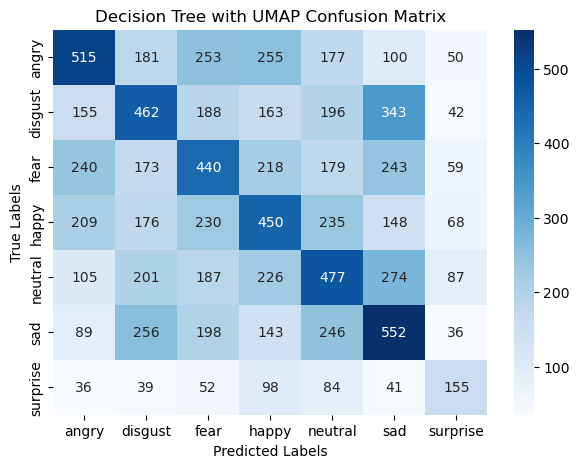

KNN with UMAP - Accuracy: 0.34388489208633094, F1-score: 0.3423574107200115, Recall: 0.34388489208633094, Precision: 0.3430672449446672
Confusion Matrix:
[[695 164 220 222 122  78  30]
 [227 549 170 121 176 282  24]
 [288 227 446 208 156 185  42]
 [305 179 213 444 207 113  55]
 [135 214 187 217 523 227  54]
 [119 307 181 114 225 550  24]
 [ 49  46  61  97  75  38 139]]



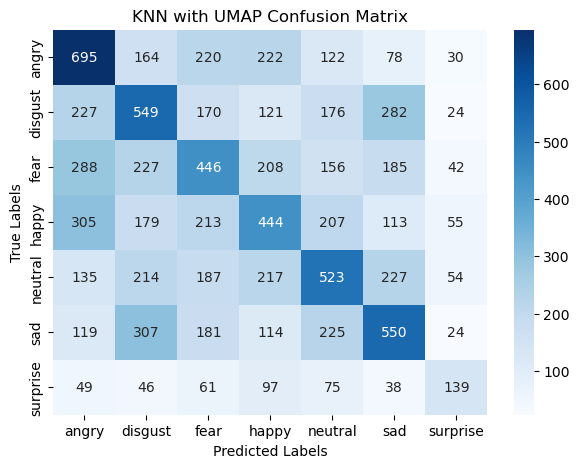

In [11]:
for model, metrics in results.items():
    print(f"{model} - Accuracy: {metrics[0]}, F1-score: {metrics[1]}, Recall: {metrics[2]}, Precision: {metrics[3]}")
    print(f"Confusion Matrix:\n{metrics[4]}\n")
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(metrics[4], annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y), yticklabels=np.unique(Y))
    plt.title(f'{model} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()